In [1]:
%matplotlib inline
import os

import pystan
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import arviz as az

## MCMCサンプルの抽出と図示

In [2]:
# データの読み込み
file_beer_sales_1 = pd.read_csv('book-data/2-4-1-beer-sales-1.csv')
print(file_beer_sales_1.head())

    sales
0   87.47
1  103.67
2   83.29
3  131.91
4  106.59


In [4]:
sample_size = len(file_beer_sales_1)

# stan用データの作成
stan_data = {
    'N': sample_size,
    'sales': file_beer_sales_1['sales']
    }

In [5]:
# pklファイルがあることを確認
if not os.path.exists('2-4-1-calc-mean-variance.pkl'):
    print("Please execute 2-4.py in advance.")
    exit()

In [6]:
# MCMCの実行
sm = pickle.load(open('2-4-1-calc-mean-variance.pkl', 'rb'))
mcmc_result = sm.sampling(
    data = stan_data,
    seed = 1,
    chains = 4,
    iter = 2000,
    warmup = 1000,
    thin = 1
)

In [7]:
# 結果の抽出
ms = mcmc_result.extract(permuted=False, inc_warmup=False)

print(type(ms))
print(ms.shape)

<class 'numpy.ndarray'>
(1000, 4, 3)


In [9]:
# 結果の一部を確認
print(ms[0, 0, 0])
print(ms[:, 0, 0])
print(ms[:, 0, 0].shape)
print(ms[:, :, 0].shape)

101.22387730794135
[101.22387731 101.22387731  98.93469033 104.8974116  101.99273717
 101.82130854  99.66316443 104.05653803 103.46469382  99.42328499
 101.30272552 101.33183761 103.63746841 100.58714728 102.43264436
 104.45144482 100.79004051 101.62596756 101.23862721  99.92686932
 102.73511351 102.53644744 106.06589811 100.03421357 102.46047818
 104.29586858 103.81503327  99.37428638 100.98803499 102.98471944
 103.09220102 102.06203274 100.61129237 102.27640642 102.01314112
 102.07813204 105.37976138 105.1075165  104.55710182 102.08242212
 102.36769384 102.9392104  101.90913669 102.04285149  99.99542592
 102.46620938 103.92767548 107.34006543 103.61360178 105.07283833
 101.63461672 101.85617142 102.93830926 101.06506535 100.5618119
 104.53753114 102.31962535 105.88970333 103.76442625 101.53784747
 102.84771195 102.6337408  103.11641778 104.87585951 103.32619231
 103.3000969  105.91951945  98.56048071 105.80633009 101.76230934
 102.41436246 101.21955166 102.8958283  102.28464433 101.7

In [10]:
# パラメータmuの情報
mu_mcmc_vec = ms[:, :, 0].reshape(4000)
print(mu_mcmc_vec.shape)

# median
print(np.median(mu_mcmc_vec))

# mean
print(np.mean(mu_mcmc_vec))

print(np.quantile(mu_mcmc_vec, q=0.025))
print(np.quantile(mu_mcmc_vec, q=0.975))

(4000,)
102.21408630165251
102.20982200182672
98.62099225373926
105.79883368456106


In [12]:
# プロットの準備
iter_from = mcmc_result.sim['warmup']
iter_range = np.arange(0, ms.shape[0])

paraname = mcmc_result.sim['fnames_oi']
print(paraname)

['mu', 'sigma', 'lp__']


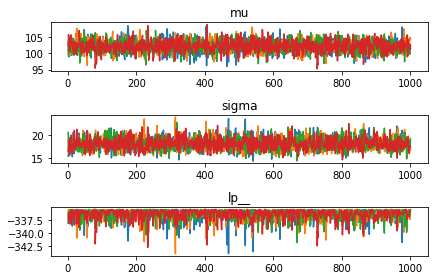

In [13]:
palette = sns.color_palette()
plt.figure()

# トレースプロット
for pi in range(len(paraname)):
    plt.subplot(3, 1, pi+1)
    plt.tight_layout()
    [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
    plt.title(paraname[pi])
plt.show()

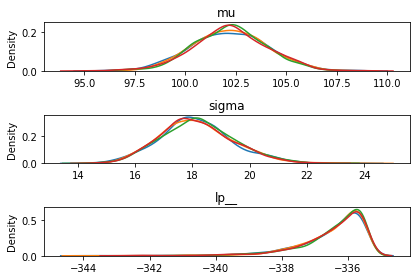

In [14]:
# パラメータの事後分布の可視化
for pi in range(len(paraname)):
    plt.subplot(3, 1, pi+1)
    plt.tight_layout()
    [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
    plt.title(paraname[pi])
plt.show()

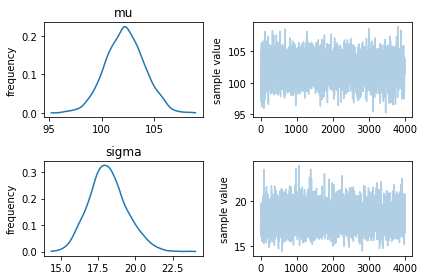

In [19]:
# まとめて表示
mcmc_result.plot()
plt.tight_layout()
plt.show()

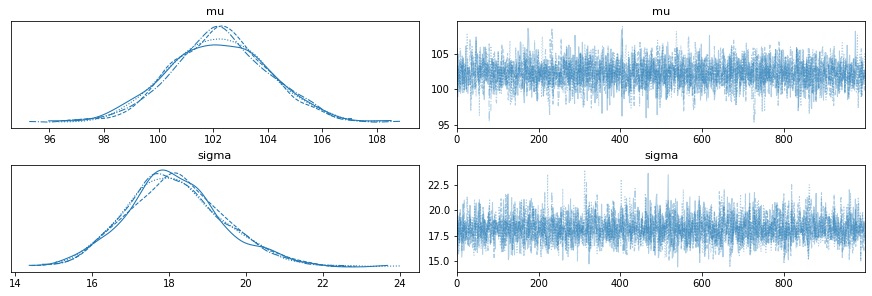

In [20]:
# baysplotの代わりにarvizを用いて可視化
az.plot_trace(data=mcmc_result)
plt.show()

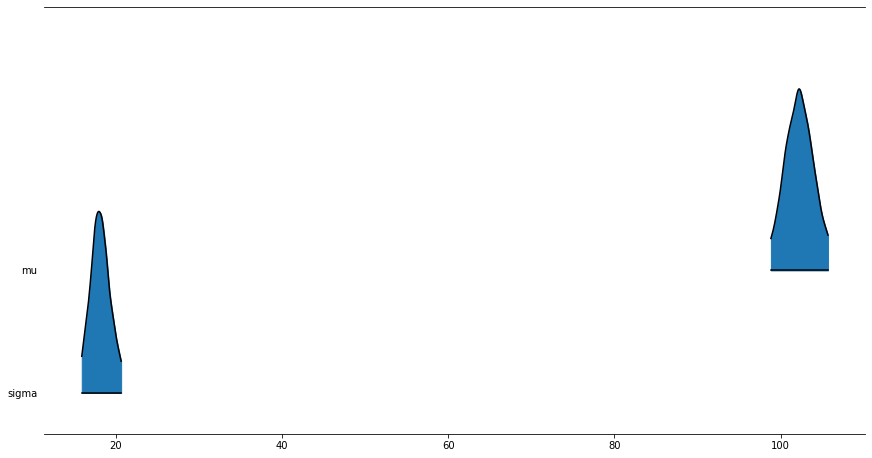

In [22]:
# 事後分布の比較(Rのmcmc_intervalsの代わり)
az.plot_forest(data=mcmc_result, kind='ridgeplot', combined=True)
plt.show()

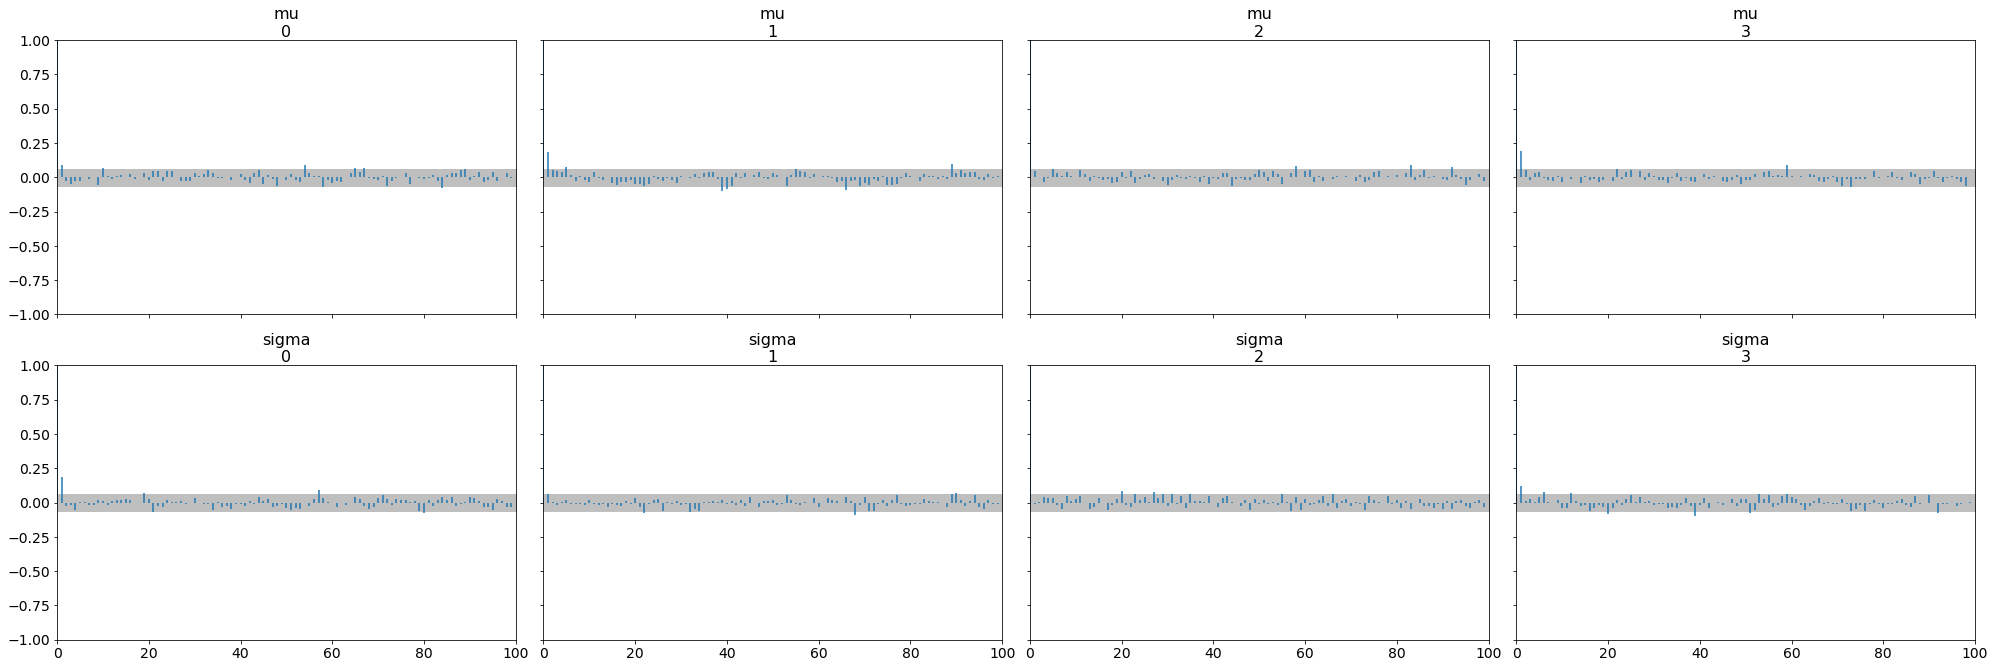

In [23]:
# 自己相関の表示
az.plot_autocorr(data=mcmc_result)
plt.show()

## 事後予測チェック

In [25]:
# データ読み込み
animal_num = pd.read_csv('book-data/2-5-1-animal-num.csv')
print(animal_num.head())

   animal_num
0           0
1           1
2           1
3           2
4           0


In [26]:
# stanデータの作成
sample_size = len(animal_num)
print(sample_size)

stan_data = {
    'N': sample_size,
    'animal_num':animal_num['animal_num']
}

200


In [28]:
# 正規分布を仮定してMCMCを実行

# stanファイルの読み込み
if os.path.exists('2-5-1-normal-dist.pkl'):
    sm_n = pickle.load(open('2-5-1-normal-dist.pkl', 'rb'))
else:
    sm_n = pystan.StanModel(file='book-data/2-5-1-normal-dist.stan')

# MCMCを実行
mcmc_n_result = sm_n.sampling(
    data = stan_data,
    seed = 1,
    chains = 4,
    iter = 2000,
    thin = 1
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85b83b3ded3d2adf738b13d45fe6740e NOW.
C:\Users\s44990\AppData\Local\Programs\Python\virtualenvs\py38_pystan2_17\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\s44990\AppData\Local\Temp\tmplu1n9n_w\stanfit4anon_model_85b83b3ded3d2adf738b13d45fe6740e_5088081270718058549.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [29]:
# saving complied model
with open('2-5-1-normal-dist.pkl', 'wb') as f:
    pickle.dump(sm_n, f)

In [30]:
# ポアソン分布を仮定してMCMCを実行

# stanファイルの読み込み
if os.path.exists('2-5-1-poisson-dist.pkl'):
    sm_p = pickle.load(open('2-5-1-poisson-dist.pkl', 'rb'))
else:
    sm_p = pystan.StanModel(file='book-data/2-5-1-poisson-dist.stan')

# MCMCを実行
mcmc_p_result = sm_p.sampling(
    data = stan_data,
    seed = 1,
    chains = 4,
    iter = 2000,
    warmup = 1000,
    thin = 1
)

# saving complied model
with open('2-5-1-poisson-dist.pkl', 'wb') as f:
    pickle.dump(sm_p, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_933b8719a6f419cd9650c470b1709556 NOW.
C:\Users\s44990\AppData\Local\Programs\Python\virtualenvs\py38_pystan2_17\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\s44990\AppData\Local\Temp\tmpa1mz7710\stanfit4anon_model_933b8719a6f419cd9650c470b1709556_2512169582388480047.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [42]:
# 結果を格納
y_rep_normal = mcmc_n_result.extract()
y_rep_poisson = mcmc_p_result.extract()

In [43]:
y_rep_poisson.shape

AttributeError: 'collections.OrderedDict' object has no attribute 'shape'

In [39]:
# 結果を格納
y_rep_normal = mcmc_n_result.extract(permuted=False, inc_warmup=True)
y_rep_normal.shape

(2000, 4, 203)

In [41]:
# 結果を格納
y_rep_poisson = mcmc_p_result.extract(permuted=False, inc_warmup=True)
y_rep_poisson.shape

(2000, 4, 202)

In [40]:
print(y_rep_normal)

[[[ 5.66911870e+00  6.69920192e+00  1.64793920e+01 ... -1.36669742e+00
    8.69280522e+00 -4.26929874e+02]
  [ 7.28332638e-01  9.77855775e-01 -5.89328460e-01 ...  5.69702278e-01
    4.02194240e-01 -9.38477313e+01]
  [ 1.62453276e-01  1.82402102e+00 -6.04397690e-01 ...  2.67288313e+00
    1.11704382e+00 -1.68962903e+02]
  [ 3.73004162e-01  4.89147942e-01  1.29808358e-01 ...  3.49430548e-01
   -9.65982187e-04 -3.88192278e+02]]

 [[ 5.66911870e+00  6.69920192e+00  1.24640044e+01 ...  1.54327733e+00
    1.80469919e+01 -4.26929874e+02]
  [ 7.28332638e-01  9.77855775e-01  9.78428487e-01 ... -3.28421936e-01
    2.21287830e+00 -9.38477313e+01]
  [ 1.62453276e-01  1.82402102e+00 -5.35033787e-01 ...  1.24286341e+00
    1.85073191e+00 -1.68962903e+02]
  [ 3.73004162e-01  4.89147942e-01 -8.30772855e-03 ...  4.47285155e-01
    7.08551385e-01 -3.88192278e+02]]

 [[ 5.66911870e+00  6.69920192e+00  7.11124789e+00 ... -4.01285395e+00
   -9.50340411e+00 -4.26929874e+02]
  [ 7.28332638e-01  9.77855775e-0

In [32]:
# 事後予測分布の出力
print(y_rep_normal['posterior_predictive'].shape)
print(y_rep_poisson['posterior_predictive'].shape)

(4000, 200)
(4000, 200)


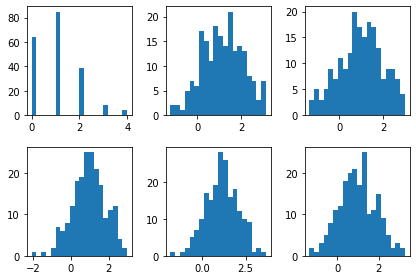

In [35]:
# 事後予測分布の図示(正規分布)
# 1-5回目のMCMCサンプルを図示

plt.figure()
plt.subplot(2, 3, 1)
plt.tight_layout()
plt.hist(animal_num['animal_num'], bins=20)

plt.subplot(2, 3, 2)
plt.tight_layout()
plt.hist(y_rep_normal['posterior_predictive'][0], bins=20)

plt.subplot(2, 3, 3)
plt.tight_layout()
plt.hist(y_rep_normal['posterior_predictive'][1], bins=20)

plt.subplot(2, 3, 4)
plt.tight_layout()
plt.hist(y_rep_normal['posterior_predictive'][2], bins=20)

plt.subplot(2, 3, 5)
plt.tight_layout()
plt.hist(y_rep_normal['posterior_predictive'][3], bins=20)

plt.subplot(2, 3, 6)
plt.tight_layout()
plt.hist(y_rep_normal['posterior_predictive'][4], bins=20)

plt.show()

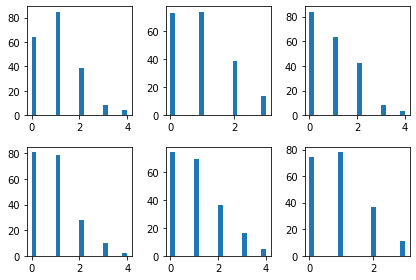

In [37]:
# 事後予測分布の図示(ポアソン分布)
# 1-5回目のMCMCサンプルを図示

plt.figure()
plt.subplot(2, 3, 1)
plt.tight_layout()
plt.hist(animal_num['animal_num'], bins=20)

plt.subplot(2, 3, 2)
plt.tight_layout()
plt.hist(y_rep_poisson['posterior_predictive'][0], bins=20)

plt.subplot(2, 3, 3)
plt.tight_layout()
plt.hist(y_rep_poisson['posterior_predictive'][1], bins=20)

plt.subplot(2, 3, 4)
plt.tight_layout()
plt.hist(y_rep_poisson['posterior_predictive'][2], bins=20)

plt.subplot(2, 3, 5)
plt.tight_layout()
plt.hist(y_rep_poisson['posterior_predictive'][3], bins=20)

plt.subplot(2, 3, 6)
plt.tight_layout()
plt.hist(y_rep_poisson['posterior_predictive'][4], bins=20)

plt.show()

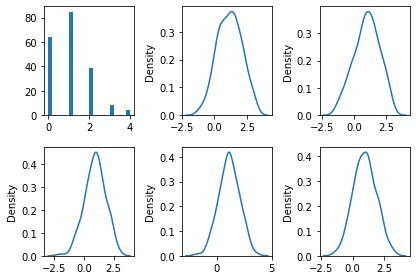

In [38]:
# 事後予測分布の図示(正規分布)
# 1-5回目のMCMCサンプルを図示
# カーネル密度推定

plt.figure()
plt.subplot(2, 3, 1)
plt.tight_layout()
plt.hist(animal_num['animal_num'], bins=20)

plt.subplot(2, 3, 2)
plt.tight_layout()
sns.kdeplot(y_rep_normal['posterior_predictive'][0])

plt.subplot(2, 3, 3)
plt.tight_layout()
sns.kdeplot(y_rep_normal['posterior_predictive'][1])

plt.subplot(2, 3, 4)
plt.tight_layout()
sns.kdeplot(y_rep_normal['posterior_predictive'][2])

plt.subplot(2, 3, 5)
plt.tight_layout()
sns.kdeplot(y_rep_normal['posterior_predictive'][3])

plt.subplot(2, 3, 6)
plt.tight_layout()
sns.kdeplot(y_rep_normal['posterior_predictive'][4])

plt.show()